#CODE  FOR IMPORTING LIBRARIES AND TRAIN AND VALIDATE THE MODELS ALONG WITH GENERATING 8 IMPORTANT EVALUATION MATRIX


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier # New import for CatBoost
import numpy as np

# --- Basic Code Setup ---

# Load the dataset
try:
    df = pd.read_csv('final_dataset_with_encoded_dates.csv')
except FileNotFoundError:
    print("Error: 'final_dataset_with_encoded_dates.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Preprocessing for 'Policy_BI' and potentially other columns that might contain 'X/Y' string format
def parse_bi_limit(limit_str):
    if isinstance(limit_str, str) and '/' in limit_str:
        try:
            parts = limit_str.split('/')
            return float(parts[0]) + float(parts[1])
        except ValueError:
            return np.nan # Return NaN if conversion fails for parts
    try:
        return float(limit_str) # Convert to float if it's already a number or can be converted
    except ValueError:
        return np.nan # Return NaN for other unparseable strings

# Apply the parsing function to 'Policy_BI'
df['Policy_BI'] = df['Policy_BI'].apply(parse_bi_limit)

# For any NaN values introduced by parsing errors or original NaNs, fill with the median
df['Policy_BI'].fillna(df['Policy_BI'].median(), inplace=True)

# Identify features (X) and target (y)
X = df.drop('Fraud_Ind', axis=1)
y = df['Fraud_Ind']

# Identify categorical columns that need encoding (excluding already encoded date columns)
categorical_cols = [
    'Policy_State', 'Gender', 'Education', 'Occupation', 'Hobbies',
    'Insured_Relationship', 'Garage_Location', 'Accident_Type', 'Collision_Type',
    'Accident_Severity', 'authorities_contacted', 'Property_Damage',
    'Bodily_Injuries', 'Police_Report', 'Auto_Make', 'Auto_Model', 'Vehicle_Color',
    'Acccident_State', 'Acccident_City'
]

# Filter categorical_cols to only include columns that actually exist in X
categorical_cols = [col for col in categorical_cols if col in X.columns]

# Apply one-hot encoding to categorical features
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Ensure all columns are numeric after one-hot encoding by converting them to numeric, coercing errors to NaN
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Fill any new NaNs introduced by the above conversion with 0 or a suitable value (e.g., mean/median)
X.fillna(0, inplace=True)


# Encode the target variable 'Fraud_Ind' (Y/N to 1/0)
le = LabelEncoder()
y = le.fit_transform(y) # Y will be 1, N will be 0

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Function to evaluate and print metrics for a given model
def evaluate_model(model_name, y_true, y_pred, y_proba=None):
    """
    Evaluates a classification model and prints 8 important metrics.
    """
    print(f"\n--- Evaluation for: {model_name} ---")

    # 1. Accuracy Score
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # 2-4. Precision, Recall, F1-Score (weighted averages) from Classification Report
    print("\nClassification Report (Weighted Averages):")
    report = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)
    precision_w = report['weighted avg']['precision']
    recall_w = report['weighted avg']['recall']
    f1_w = report['weighted avg']['f1-score']
    print(f"  Precision (weighted): {precision_w:.4f}")
    print(f"  Recall (weighted):    {recall_w:.4f}")
    print(f"  F1-Score (weighted):  {f1_w:.4f}")

    # 5. ROC AUC Score
    if y_proba is not None and y_proba.ndim > 1 and y_proba.shape[1] > 1:
        roc_auc = roc_auc_score(y_true, y_proba[:, 1])
        print(f"ROC AUC Score: {roc_auc:.4f}")
    elif y_proba is not None and y_proba.ndim == 1:
         roc_auc = roc_auc_score(y_true, y_proba)
         print(f"ROC AUC Score: {roc_auc:.4f}")
    else:
        print("ROC AUC Score: Not applicable (probability predictions not available or incorrect shape)")

    # 6. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # 7. Full Classification Report
    print("\nFull Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    # 8. Cohen's Kappa Score
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa Score: {kappa:.4f}")


# --- Step-by-Step Algorithms ---

print("--- Starting Classification Algorithms ---")

# 1. Logistic Regression
print("\n--- Logistic Regression ---")
log_reg = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)
evaluate_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)

# 2. Decision Tree Classifier
print("\n--- Decision Tree Classifier ---")
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
y_proba_dt = dt_classifier.predict_proba(X_test)
evaluate_model("Decision Tree Classifier", y_test, y_pred_dt, y_proba_dt)

# 3. Random Forest Classifier
print("\n--- Random Forest Classifier ---")
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
y_proba_rf = rf_classifier.predict_proba(X_test)
evaluate_model("Random Forest Classifier", y_test, y_pred_rf, y_proba_rf)

# 4. Gradient Boosting Classifier
print("\n--- Gradient Boosting Classifier ---")
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
y_pred_gb = gb_classifier.predict(X_test)
y_proba_gb = gb_classifier.predict_proba(X_test)
evaluate_model("Gradient Boosting Classifier", y_test, y_pred_gb, y_proba_gb)

# 5. K-Nearest Neighbors (KNeighborsClassifier)
print("\n--- K-Nearest Neighbors (KNeighborsClassifier) ---")
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
y_proba_knn = knn_classifier.predict_proba(X_test)
evaluate_model("K-Nearest Neighbors (KNeighborsClassifier)", y_test, y_pred_knn, y_proba_knn)

# 6. Naive Bayes (GaussianNB)
print("\n--- Naive Bayes (GaussianNB) ---")
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)
y_pred_gnb = gnb_classifier.predict(X_test)
y_proba_gnb = gnb_classifier.predict_proba(X_test)
evaluate_model("Naive Bayes (GaussianNB)", y_test, y_pred_gnb, y_proba_gnb)

# 7. XGBoost Classifier
print("\n--- XGBoost Classifier ---")
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
y_proba_xgb = xgb_classifier.predict_proba(X_test)
evaluate_model("XGBoost Classifier", y_test, y_pred_xgb, y_proba_xgb)

# 8. LightGBM Classifier
print("\n--- LightGBM Classifier ---")
lgb_classifier = lgb.LGBMClassifier(objective='binary', random_state=42)
lgb_classifier.fit(X_train, y_train)
y_pred_lgb = lgb_classifier.predict(X_test)
y_proba_lgb = lgb_classifier.predict_proba(X_test)
evaluate_model("LightGBM Classifier", y_test, y_pred_lgb, y_proba_lgb)

# 9. CatBoost Classifier (Alternative to SVC)
print("\n--- CatBoost Classifier ---")
# CatBoost is good at handling categorical features automatically, but since we already one-hot encoded,
# we can train it like other models.
cat_classifier = CatBoostClassifier(iterations=100,  # Number of trees
                                     learning_rate=0.1,
                                     depth=6,
                                     loss_function='Logloss',
                                     eval_metric='Accuracy',
                                     verbose=False, # Set to True for progress updates
                                     random_seed=42)
cat_classifier.fit(X_train, y_train)
y_pred_cat = cat_classifier.predict(X_test)
y_proba_cat = cat_classifier.predict_proba(X_test)
evaluate_model("CatBoost Classifier", y_test, y_pred_cat, y_proba_cat)


# 10. AdaBoost Classifier
print("\n--- AdaBoost Classifier ---")
ada_classifier = AdaBoostClassifier(random_state=42)
ada_classifier.fit(X_train, y_train)
y_pred_ada = ada_classifier.predict(X_test)
y_proba_ada = ada_classifier.predict_proba(X_test)
evaluate_model("AdaBoost Classifier", y_test, y_pred_ada, y_proba_ada)

/tmp/ipython-input-5-64669743.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Policy_BI'].fillna(df['Policy_BI'].median(), inplace=True)


--- Starting Classification Algorithms ---

--- Logistic Regression ---

--- Evaluation for: Logistic Regression ---
Accuracy: 0.7467

Classification Report (Weighted Averages):
  Precision (weighted): 0.5575
  Recall (weighted):    0.7467
  F1-Score (weighted):  0.6384
ROC AUC Score: 0.5579

Confusion Matrix:
[[13440     0]
 [ 4560     0]]

Full Classification Report:
              precision    recall  f1-score   support

           N       0.75      1.00      0.85     13440
           Y       0.00      0.00      0.00      4560

    accuracy                           0.75     18000
   macro avg       0.37      0.50      0.43     18000
weighted avg       0.56      0.75      0.64     18000

Cohen's Kappa Score: 0.0000

--- Decision Tree Classifier ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


--- Evaluation for: Decision Tree Classifier ---
Accuracy: 1.0000

Classification Report (Weighted Averages):
  Precision (weighted): 1.0000
  Recall (weighted):    1.0000
  F1-Score (weighted):  1.0000
ROC AUC Score: 1.0000

Confusion Matrix:
[[13440     0]
 [    0  4560]]

Full Classification Report:
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     13440
           Y       1.00      1.00      1.00      4560

    accuracy                           1.00     18000
   macro avg       1.00      1.00      1.00     18000
weighted avg       1.00      1.00      1.00     18000

Cohen's Kappa Score: 1.0000

--- Random Forest Classifier ---

--- Evaluation for: Random Forest Classifier ---
Accuracy: 1.0000

Classification Report (Weighted Averages):
  Precision (weighted): 1.0000
  Recall (weighted):    1.0000
  F1-Score (weighted):  1.0000
ROC AUC Score: 1.0000

Confusion Matrix:
[[13440     0]
 [    0  4560]]

Full Classification Report:
 

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:09:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Evaluation for: XGBoost Classifier ---
Accuracy: 1.0000

Classification Report (Weighted Averages):
  Precision (weighted): 1.0000
  Recall (weighted):    1.0000
  F1-Score (weighted):  1.0000
ROC AUC Score: 1.0000

Confusion Matrix:
[[13440     0]
 [    0  4560]]

Full Classification Report:
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     13440
           Y       1.00      1.00      1.00      4560

    accuracy                           1.00     18000
   macro avg       1.00      1.00      1.00     18000
weighted avg       1.00      1.00      1.00     18000

Cohen's Kappa Score: 1.0000

--- LightGBM Classifier ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 10640, number of negative: 31360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

#SAVING THE BEST FILE IN (.joblib) FILE FORMAT i.e., Gradient_boosting_classifier_model.joblib


In [13]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier

# Load the dataset
df = pd.read_csv('final_dataset_with_encoded_dates.csv')

# Preprocessing 'Policy_BI'
def parse_bi_limit(limit_str):
    if isinstance(limit_str, str) and '/' in limit_str:
        try:
            parts = limit_str.split('/')
            return float(parts[0]) + float(parts[1])
        except ValueError:
            return np.nan
    try:
        return float(limit_str)
    except ValueError:
        return np.nan

df['Policy_BI'] = df['Policy_BI'].apply(parse_bi_limit)
df['Policy_BI'].fillna(df['Policy_BI'].median(), inplace=True)

# Features and target
X = df.drop('Fraud_Ind', axis=1)
y = df['Fraud_Ind']

# Encode categorical features
categorical_cols = [
    'Policy_State', 'Gender', 'Education', 'Occupation', 'Hobbies',
    'Insured_Relationship', 'Garage_Location', 'Accident_Type', 'Collision_Type',
    'Accident_Severity', 'authorities_contacted', 'Property_Damage',
    'Bodily_Injuries', 'Police_Report', 'Auto_Make', 'Auto_Model', 'Vehicle_Color',
    'Acccident_State', 'Acccident_City'
]
categorical_cols = [col for col in categorical_cols if col in X.columns]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Ensure numeric and handle NaNs
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')
X.fillna(0, inplace=True)

# Encode target
le = LabelEncoder()
y = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

# Save model
joblib.dump(gb_classifier, 'gradient_boosting_classifier_model.joblib')
print("Gradient Boosting model saved as 'gradient_boosting_classifier_model.joblib'")


/tmp/ipython-input-13-2400054948.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Policy_BI'].fillna(df['Policy_BI'].median(), inplace=True)


Gradient Boosting model saved as 'gradient_boosting_classifier_model.joblib'


#Predicting the Fraud_Ind by using the best model saved

In [19]:
import pandas as pd
import joblib

# Load the trained model
model = joblib.load('gradient_boosting_classifier_model.joblib')

# Load the datasets
new_data = pd.read_csv('Auto_Insurance_Fraud_Claims_File03.csv')
submission_template = pd.read_csv('Auto_Insurance_Fraud_Claims_Results_Submission.csv')

# Get expected features from model
expected_features = model.feature_names_in_

# Preprocessing (must match training)
# 1. Date features
date_cols = [col for col in new_data.columns if 'date' in col.lower()]
for col in date_cols:
    new_data[col] = pd.to_datetime(new_data[col])
    new_data[f'{col}_year'] = new_data[col].dt.year
    new_data[f'{col}_month'] = new_data[col].dt.month
    new_data[f'{col}_day'] = new_data[col].dt.day
    new_data[f'{col}_dayofweek'] = new_data[col].dt.dayofweek
    new_data = new_data.drop(col, axis=1)

# 2. One-hot encode categoricals
cat_cols = new_data.select_dtypes(include=['object']).columns
new_data = pd.get_dummies(new_data, columns=cat_cols)

# Align features with model expectations
for feature in expected_features:
    if feature not in new_data.columns:
        new_data[feature] = 0
new_data = new_data[expected_features]

# Generate predictions
fraud_pred_numeric = model.predict(new_data)  # 1/0 predictions
fraud_prob = model.predict_proba(new_data)[:, 1]  # Probability of fraud

# Create results DataFrame with Y/N for both Fraud_Ind and Fraud_Pred
results = pd.DataFrame({
    'Claim_ID': submission_template['Claim_ID'],
    'Fraud_Ind': ['Y' if x == 1 else 'N' for x in fraud_pred_numeric],
    'Fraud_Pred': ['Y' if x == 1 else 'N' for x in fraud_pred_numeric],
    'Fraud_Probability': fraud_prob
})

# Save to CSV
results.to_csv('fraud_predictions_complete_yn_format.csv', index=False)
print("Results saved with all columns in Y/N format!")

Results saved with all columns in Y/N format!


#Generating different types of useful plots for various insights

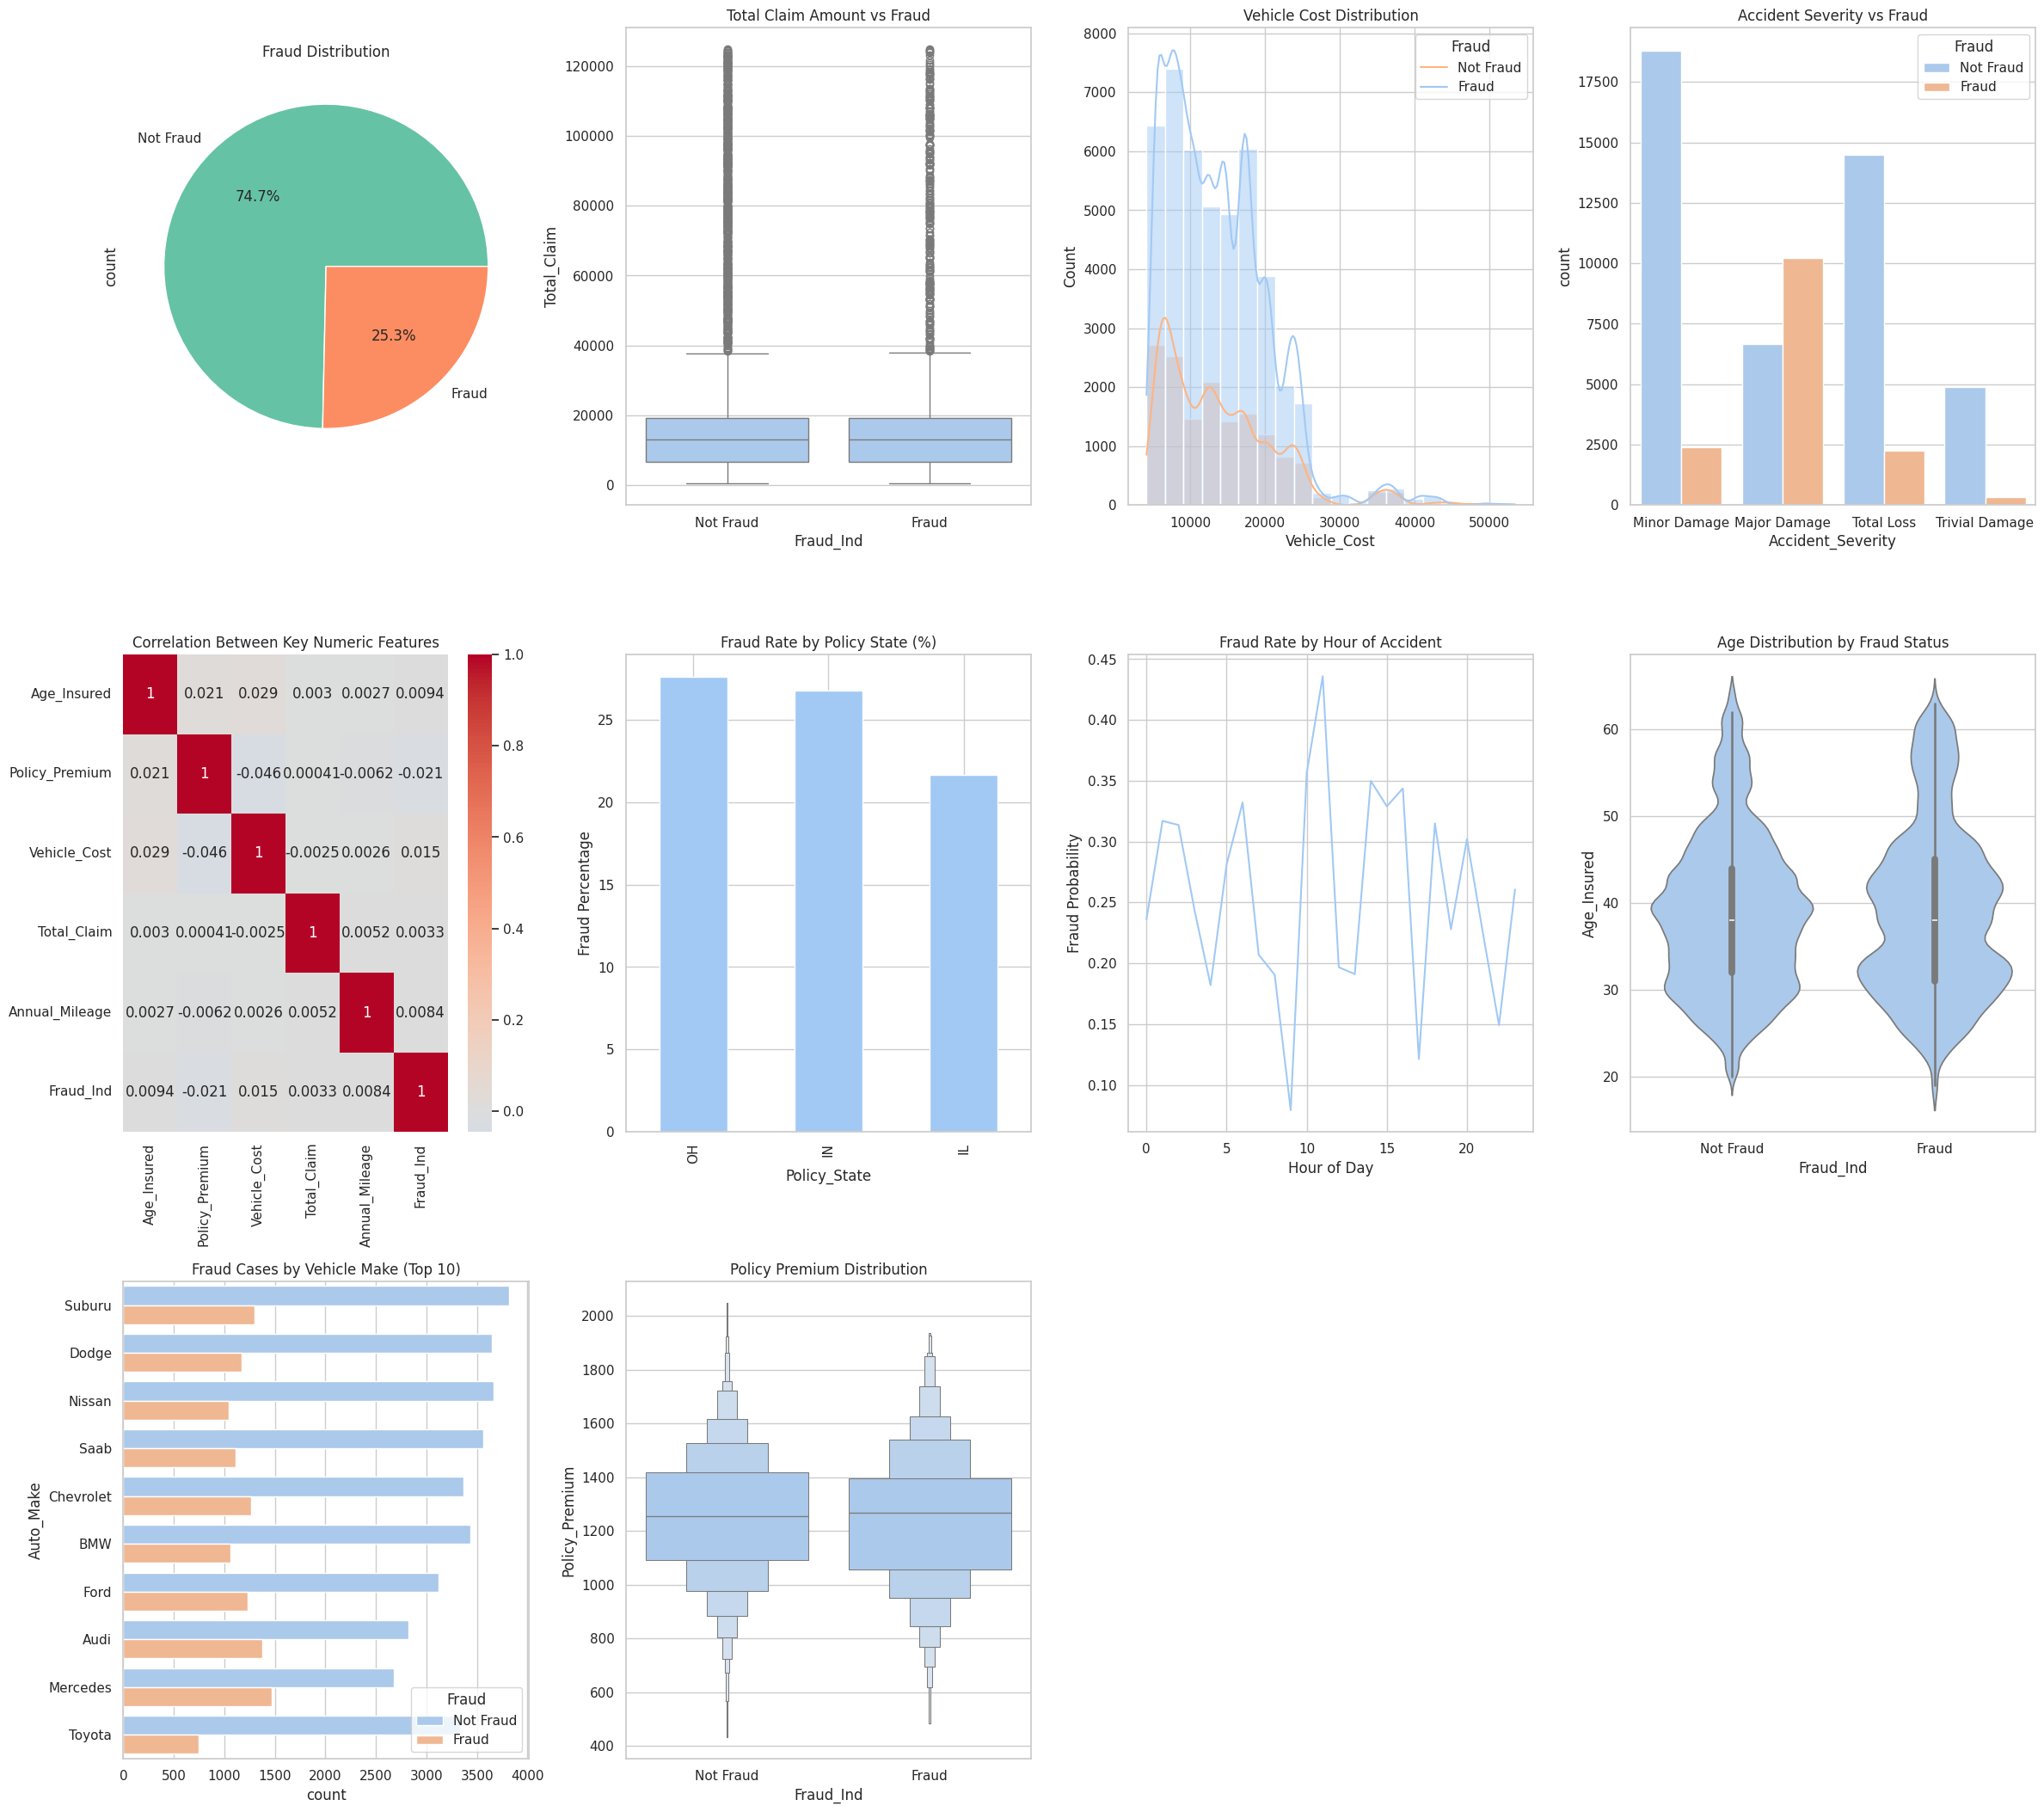

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('final_dataset_with_encoded_dates.csv')

# Convert Fraud_Ind to numeric (1 for 'Y', 0 for 'N')
df['Fraud_Ind'] = df['Fraud_Ind'].map({'Y': 1, 'N': 0})

# Set up visualization style
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(24, 28))

# 1. Fraud Distribution (Pie Chart)
plt.subplot(4, 4, 1)
df['Fraud_Ind'].value_counts().plot.pie(autopct='%1.1f%%',
                                      colors=['#66c2a5','#fc8d62'],
                                      labels=['Not Fraud', 'Fraud'])
plt.title('Fraud Distribution')

# 2. Total Claim Amount vs Fraud (Boxplot)
plt.subplot(4, 4, 2)
sns.boxplot(x='Fraud_Ind', y='Total_Claim', data=df)
plt.title('Total Claim Amount vs Fraud')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])

# 3. Vehicle Cost Distribution (Histogram)
plt.subplot(4, 4, 3)
sns.histplot(data=df, x='Vehicle_Cost', hue='Fraud_Ind', kde=True, bins=20)
plt.title('Vehicle Cost Distribution')
plt.legend(title='Fraud', labels=['Not Fraud', 'Fraud'])

# 4. Accident Severity (Bar Plot)
plt.subplot(4, 4, 4)
sns.countplot(data=df, x='Accident_Severity', hue='Fraud_Ind',
             order=df['Accident_Severity'].value_counts().index)
plt.title('Accident Severity vs Fraud')
plt.legend(title='Fraud', labels=['Not Fraud', 'Fraud'])

# 5. Correlation Heatmap (Numerical Features)
plt.subplot(4, 4, 5)
numeric_cols = ['Age_Insured', 'Policy_Premium', 'Vehicle_Cost',
               'Total_Claim', 'Annual_Mileage', 'Fraud_Ind']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Key Numeric Features')

# 6. Fraud Rate by State (Bar Plot)
plt.subplot(4, 4, 6)
(df.groupby('Policy_State')['Fraud_Ind'].mean()*100).sort_values(ascending=False).plot.bar()
plt.title('Fraud Rate by Policy State (%)')
plt.ylabel('Fraud Percentage')

# 7. Fraud Trend by Accident Hour (Line Plot)
plt.subplot(4, 4, 7)
df.groupby('Accident_Hour')['Fraud_Ind'].mean().plot()
plt.title('Fraud Rate by Hour of Accident')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Probability')

# 8. Age Distribution (Violin Plot)
plt.subplot(4, 4, 8)
sns.violinplot(x='Fraud_Ind', y='Age_Insured', data=df)
plt.title('Age Distribution by Fraud Status')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])

# 9. Vehicle Make Analysis (Top 10)
plt.subplot(4, 4, 9)
top_makes = df['Auto_Make'].value_counts().nlargest(10).index
sns.countplot(data=df[df['Auto_Make'].isin(top_makes)], y='Auto_Make',
             hue='Fraud_Ind', order=top_makes)
plt.title('Fraud Cases by Vehicle Make (Top 10)')
plt.legend(title='Fraud', labels=['Not Fraud', 'Fraud'])

# 10. Policy Premium vs Fraud (Boxen Plot)
plt.subplot(4, 4, 10)
sns.boxenplot(x='Fraud_Ind', y='Policy_Premium', data=df)
plt.title('Policy Premium Distribution')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])

plt.tight_layout()
plt.savefig('fraud_analysis_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

#Code for generating Confusion Matrix and encoding the values with error try and if block for easy code debugging


--- Debugging Pre-encoding ---
Columns in X_test BEFORE get_dummies():
['Customer_Life_Value1', 'Age_Insured', 'Policy_State', 'Policy_BI', 'Policy_Ded', 'Policy_Premium', 'Umbrella_Limit', 'Gender', 'Education', 'Occupation', 'Hobbies', 'Insured_Relationship', 'Capital_Gains', 'Capital_Loss', 'Garage_Location', 'Accident_Type', 'Collision_Type', 'Accident_Severity', 'authorities_contacted', 'Acccident_State', 'Acccident_City', 'Accident_Hour', 'Num_of_Vehicles_Involved', 'Property_Damage', 'Bodily_Injuries', 'Witnesses', 'Police_Report', 'Auto_Make', 'Auto_Model', 'Auto_Year', 'Vehicle_Color', 'Vehicle_Cost', 'Annual_Mileage', 'DiffIN_Mileage', 'Low_Mileage_Discount', 'Commute_Discount', 'Total_Claim', 'Injury_Claim', 'Property_Claim', 'Vehicle_Claim', 'Policy_Start_Date_year', 'Policy_Start_Date_month', 'Policy_Start_Date_day', 'Policy_Start_Date_dayofweek', 'Policy_Expiry_Date_year', 'Policy_Expiry_Date_month', 'Policy_Expiry_Date_day', 'Policy_Expiry_Date_dayofweek', 'Accident_Dat

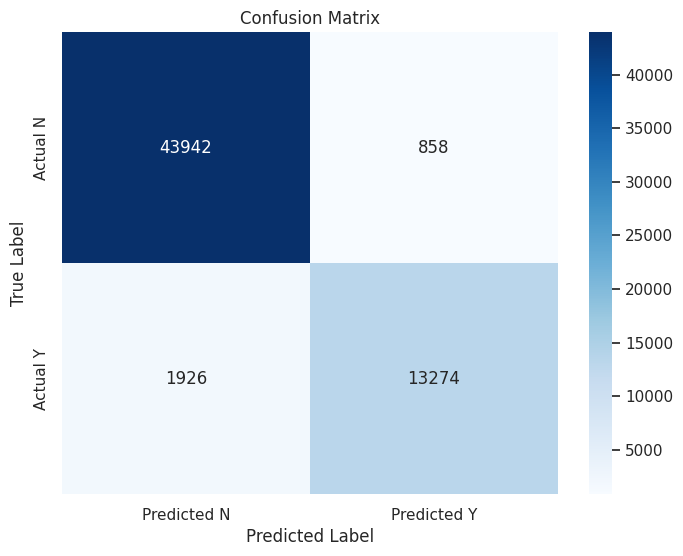


Classification Report:
               precision    recall  f1-score   support

Non-Fraud (N)       0.96      0.98      0.97     44800
    Fraud (Y)       0.94      0.87      0.91     15200

     accuracy                           0.95     60000
    macro avg       0.95      0.93      0.94     60000
 weighted avg       0.95      0.95      0.95     60000


Script finished.


In [28]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy for numerical operations
from sklearn.metrics import confusion_matrix, classification_report

# Load the trained model
try:
    model = joblib.load('gradient_boosting_classifier_model.joblib')
except FileNotFoundError:
    print("Error: 'gradient_boosting_classifier_model.joblib' not found.")
    print("Please ensure the trained model file is in the same directory.")
    exit()

# Load your test data
try:
    test_data = pd.read_csv('final_dataset_with_encoded_dates.csv')
except FileNotFoundError:
    print("Error: 'final_dataset_with_encoded_dates.csv' not found.")
    print("Please ensure your test data file is in the same directory.")
    exit()

# --- Step 1: Data Preprocessing for Test Data (Crucial for consistency) ---

# Convert Fraud_Ind to binary (if needed) - consistent with training
if 'Fraud_Ind' in test_data.columns:
    test_data['Fraud_Ind'] = test_data['Fraud_Ind'].map({'Y': 1, 'N': 0})
    y_test = test_data['Fraud_Ind']
else:
    print("Warning: 'Fraud_Ind' column not found in test_data. Assuming this is for inference only.")
    y_test = None # No true labels for evaluation

# Separate features (X) and target (y)
X_test = test_data.drop('Fraud_Ind', axis=1, errors='ignore')

# --- Handle the 'could not convert string to float' error ---
# Based on your error, '500/1000' strongly suggests Policy_BI or similar numeric column.
# Let's assume it's 'Policy_BI'. You need to apply the SAME logic as training.

# Function to clean Policy_BI or similar column
def clean_policy_bi(value):
    if pd.isna(value):
        return np.nan # Keep NaN values if they exist
    if isinstance(value, (int, float)):
        return value # Already a number
    try:
        # Attempt to split if it's a string like '500/1000'
        parts = str(value).split('/')
        if len(parts) == 2:
            # Decide how to convert. For simplicity, let's sum them
            # You MUST align this with how you processed it in training!
            return float(parts[0]) + float(parts[1]) # Example: 500/1000 -> 1500
            # Alternatively: return float(parts[0]) # Example: 500/1000 -> 500
            # Or: return float(parts[1]) # Example: 500/1000 -> 1000
        else:
            return float(value) # Try direct conversion for other strings
    except ValueError:
        print(f"Could not convert value to float: '{value}' in Policy_BI (or similar column). Setting to NaN.")
        return np.nan # Return NaN if conversion fails

# Apply this cleaning to relevant columns.
# Assuming 'Policy_BI' is the problematic column. Add others if necessary.
columns_to_clean_numerical = ['Policy_BI'] # Add other numerical columns if they could have string issues
for col in columns_to_clean_numerical:
    if col in X_test.columns:
        X_test[col] = X_test[col].apply(clean_policy_bi)
        # After cleaning, you might need to impute NaNs if your model was trained on imputed data
        # For simplicity here, we're assuming the model handles NaNs or they are rare/filled later
        # If your training had `X_train[col].fillna(X_train[col].mean(), inplace=True)` for example, do it here too:
        # X_test[col].fillna(X_test[col].mean(), inplace=True) # Or using the training data's mean

# --- Identify Categorical Columns (Based on your X_test.columns.tolist() output) ---
# THESE ARE EDUCATED GUESSES. YOU MUST CONFIRM THEM FROM YOUR TRAINING SCRIPT/DATA.
categorical_cols = [
    'Policy_State',
    'Gender',
    'Education',
    'Occupation',
    'Hobbies',
    'Insured_Relationship',
    'Garage_Location', # Assuming this is categorical from your previous output (Yes/No)
    'Accident_Type',
    'Collision_Type',
    'Accident_Severity',
    'authorities_contacted',
    'Acccident_State', # Typo from previous debug output: 'Acccident_State' vs 'Accident_State'
    'Acccident_City',  # Typo from previous debug output: 'Acccident_City' vs 'Accident_City'
    'Property_Damage', # Assuming this is categorical (Yes/No/Unknown)
    'Bodily_Injuries', # Appears to be categorical (0, 1, 2) in your model's trained features
    'Police_Report',   # Appears to be categorical (YES/NO/Unknown)
    'Auto_Make',
    'Auto_Model',
    'Vehicle_Color',
]

# --- Debugging step: Verify columns before one-hot encoding ---
print("\n--- Debugging Pre-encoding ---")
print("Columns in X_test BEFORE get_dummies():")
print(X_test.columns.tolist())
print("\nCategorical columns specified for encoding (before filtering):")
print(categorical_cols)

# Filter categorical_cols to only include those actually present in X_test
existing_categorical_cols = [col for col in categorical_cols if col in X_test.columns]
if len(existing_categorical_cols) < len(categorical_cols):
    missing_cols = set(categorical_cols) - set(existing_categorical_cols)
    print(f"\nWarning: The following categorical columns were specified but not found in X_test: {missing_cols}")
    print("These columns will be skipped for one-hot encoding.")
    print("This might indicate an inconsistency between training and test data.")

if not existing_categorical_cols:
    print("\nNo existing categorical columns found in X_test for one-hot encoding after filtering.")
else:
    print(f"\nProceeding with one-hot encoding for: {existing_categorical_cols}")
    X_test = pd.get_dummies(X_test, columns=existing_categorical_cols, drop_first=False) # drop_first must be consistent with training

print("\n--- Debugging Post-encoding ---")
print("Columns in X_test AFTER get_dummies():")
print(X_test.columns.tolist())


# --- Step 2: Align columns with training data ---
# Load the feature names from your training data. This is paramount.
try:
    # IMPORTANT: Ensure 'trained_feature_names.joblib' was saved from your *training script*
    # after all preprocessing (including one-hot encoding) was done on X_train.
    trained_features = joblib.load('trained_feature_names.joblib')
    print("\nLoaded trained feature names from 'trained_feature_names.joblib'.")
except FileNotFoundError:
    print("\nError: 'trained_feature_names.joblib' not found.")
    print("This file is crucial for aligning test data features.")
    print("Please ensure it's generated and available from your training script.")
    print("Attempting to use model.feature_names_in_ as a fallback...")
    if hasattr(model, 'feature_names_in_'):
        trained_features = model.feature_names_in_.tolist()
        print("Successfully retrieved feature names from model.feature_names_in_.")
    else:
        print("Failed to retrieve trained feature names. Cannot proceed with prediction.")
        exit() # Cannot continue without knowing model's expected features

# Reindex X_test to match the columns of the training data
# Fill missing columns (categories not in test but in training) with 0
# Drop extra columns (new categories in test not seen in training)
X_test = X_test.reindex(columns=trained_features, fill_value=0)

print("\n--- Debugging Post-alignment ---")
print("Columns in X_test AFTER alignment with trained features:")
print(X_test.columns.tolist())
print(f"Number of features in X_test: {X_test.shape[1]}")
print(f"Number of features model was trained on: {len(trained_features)}")

# Final verification that the number of columns matches
if X_test.shape[1] != len(trained_features):
    print("\nCRITICAL ERROR: The number of features in X_test after alignment does not match the number of features the model was trained on!")
    print("This indicates a severe mismatch in preprocessing or feature sets.")
    print("Please re-verify your `categorical_cols` and ensure 'trained_feature_names.joblib' is correct.")
    exit() # Exit because predictions will likely be wrong

# --- Step 3: Make predictions ---
print("\nMaking predictions...")
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class (Fraud)


# --- Step 4: Evaluate results (only if y_test is available) ---
if y_test is not None:
    print("\n--- Evaluation ---")
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted N', 'Predicted Y'],
                yticklabels=['Actual N', 'Actual Y'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Fraud (N)', 'Fraud (Y)']))
else:
    print("\nSkipping evaluation: True labels (y_test) not available in the test data.")
    print("\nPredictions (y_pred) - first 10:")
    print(y_pred[:10])
    print("\nPrediction Probabilities (y_proba for Fraud) - first 10:")
    print(y_proba[:10])

print("\nScript finished.")

#PLOTS FOR THE KPI's

Loaded 'final_dataset_with_encoded_dates.csv' for plotting.

--- Generating KPI Plots ---


/tmp/ipython-input-1-3592986546.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Non-Fraud', 'Fraud'], y=[total_claims - fraud_count, fraud_count], palette=['skyblue', 'salmon'])


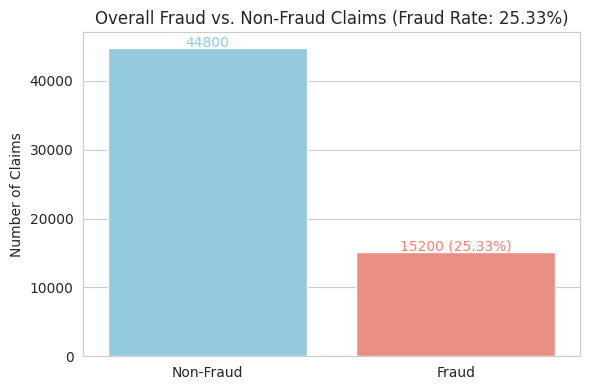

Generated 'overall_fraud_rate.png'


/tmp/ipython-input-1-3592986546.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_state_rate.index, y=fraud_by_state_rate.values, palette='viridis')


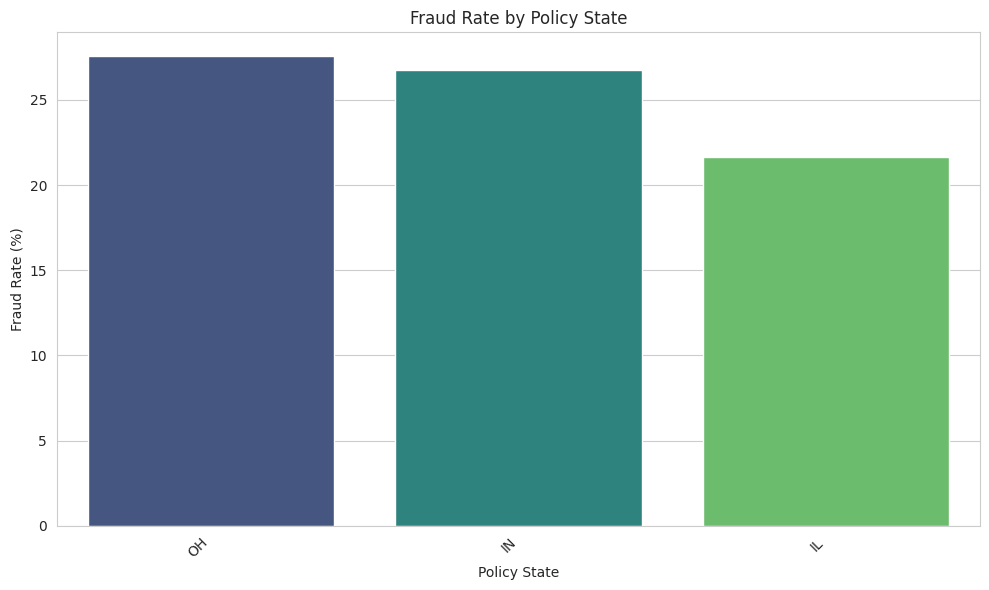

Generated 'fraud_rate_by_policy_state.png'


/tmp/ipython-input-1-3592986546.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_accident_type_rate.index, y=fraud_by_accident_type_rate.values, palette='magma')


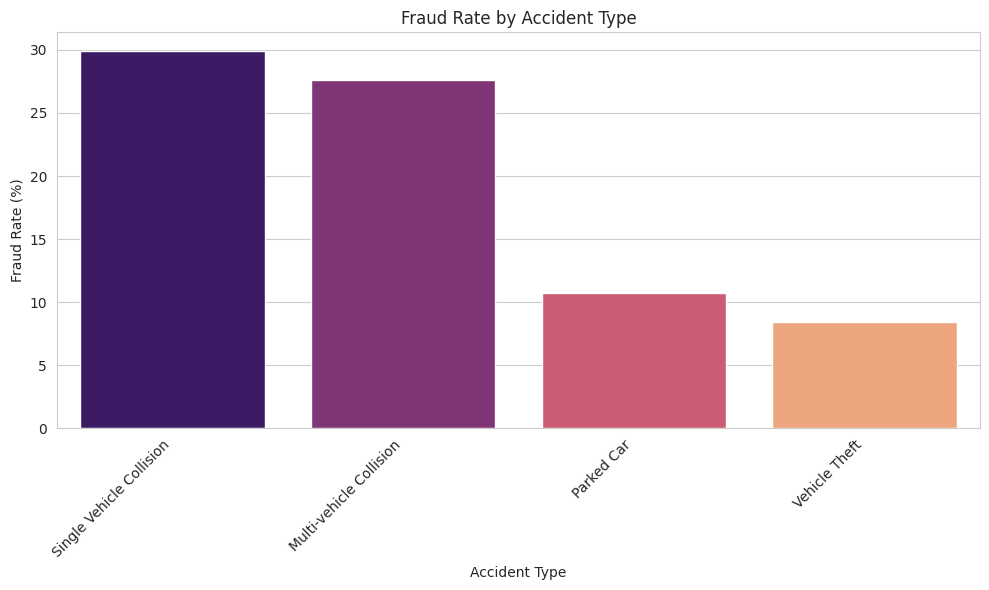

Generated 'fraud_rate_by_accident_type.png'


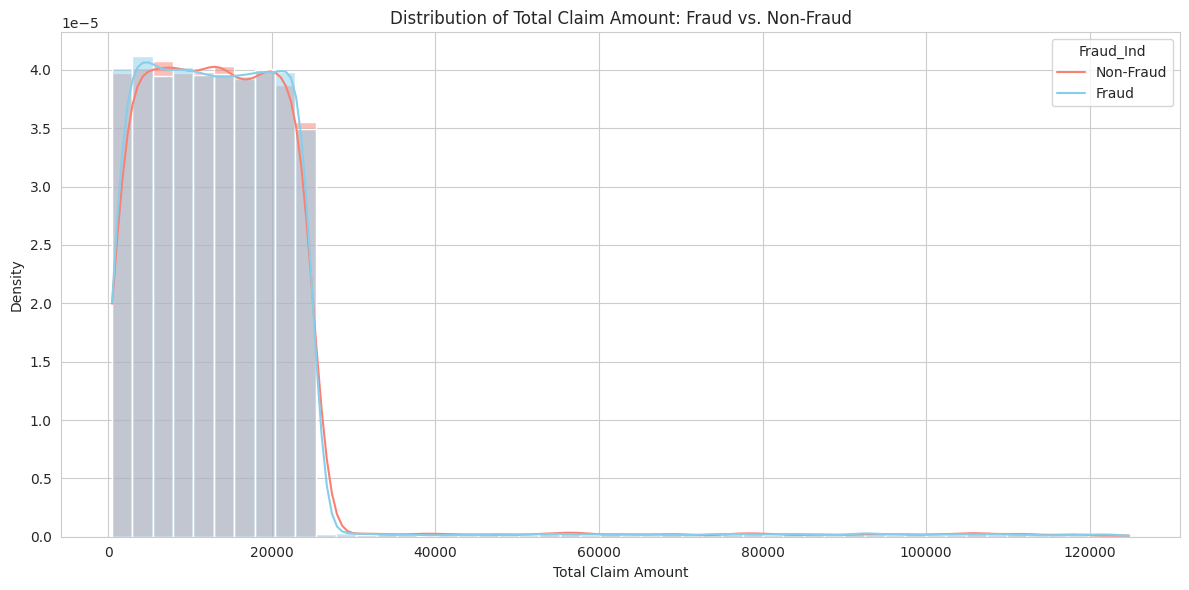

Generated 'total_claim_distribution.png'


/tmp/ipython-input-1-3592986546.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_df, x='Fraud_Ind', y='Customer_Life_Value1', palette=['skyblue', 'salmon'])


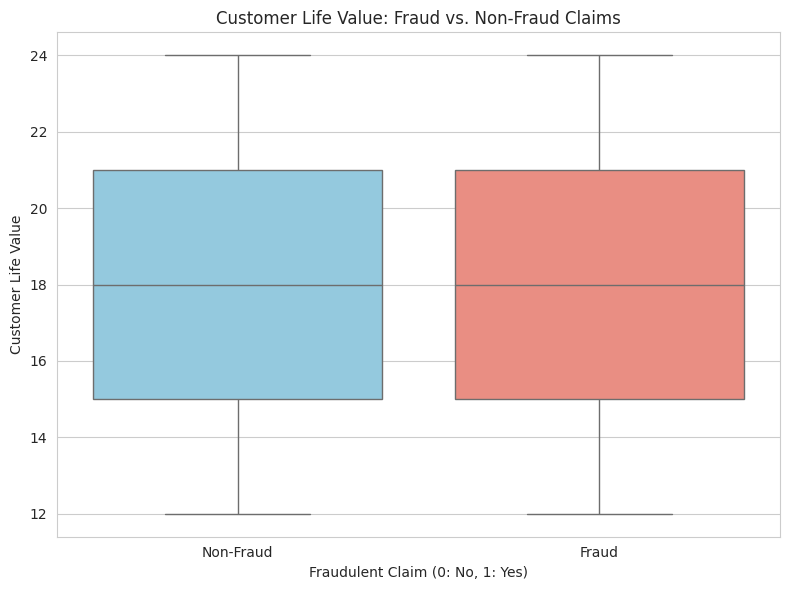

Generated 'clv_fraud_boxplot.png'


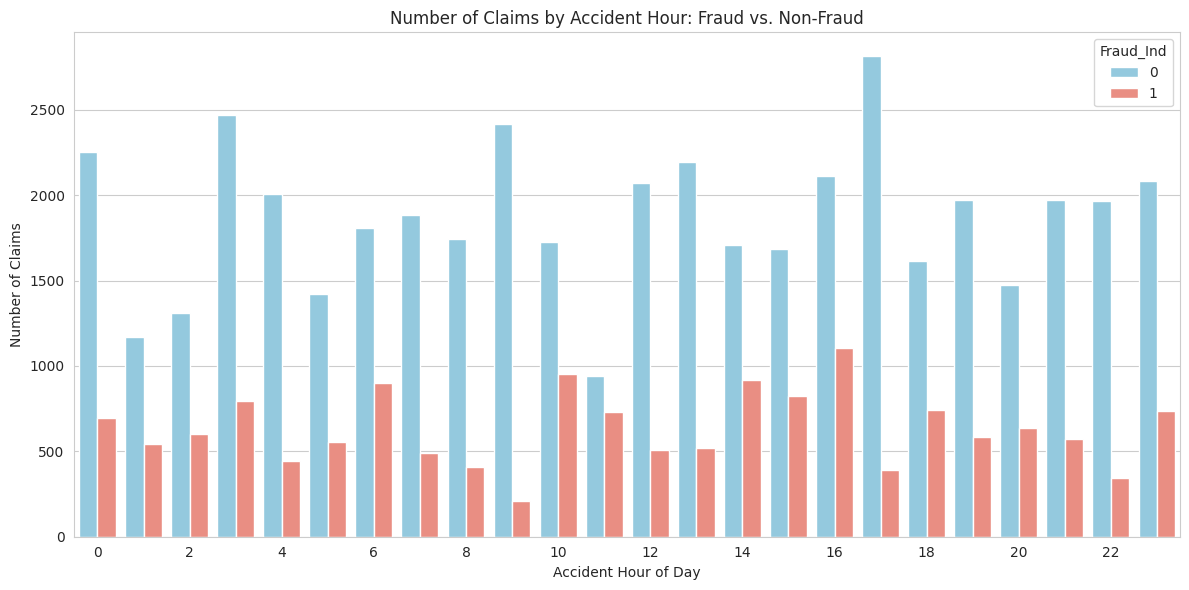

Generated 'claims_by_accident_hour.png'


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Ensure final_df is loaded and preprocessed ---
# This block assumes you have already run the full data preprocessing script
# that results in the 'final_df' DataFrame.
# If you are starting a new session, you would need to re-run your previous code
# to load, merge, and preprocess the data into 'final_df'.

# Placeholder: If you need to re-create a dummy final_df for testing this plot code
# For demonstration purposes if you're not running the full pipeline every time:
try:
    # Try to load the preprocessed file if it was saved
    final_df = pd.read_csv('final_dataset_with_encoded_dates.csv')
    print("Loaded 'final_dataset_with_encoded_dates.csv' for plotting.")

    # Apply minimal necessary preprocessing to ensure columns used in plotting are ready
    # Ensure Fraud_Ind is numeric (0/1) for calculations
    if 'Fraud_Ind' in final_df.columns:
        if final_df['Fraud_Ind'].dtype == 'object':
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            final_df['Fraud_Ind'] = le.fit_transform(final_df['Fraud_Ind']) # 'Y' will be 1, 'N' will be 0

    # Ensure other columns used in plotting are correctly typed for demonstration
    for col in ['Accident_Hour', 'Bodily_Injuries', 'Total_Claim', 'Policy_Premium']:
        if col in final_df.columns:
            final_df[col] = pd.to_numeric(final_df[col], errors='coerce').fillna(final_df[col].median() if final_df[col].dtype != 'object' else 0)

except FileNotFoundError:
    print("Error: 'final_dataset_with_encoded_dates.csv' not found. Please ensure your 'final_df' is created from previous steps.")
    print("Cannot proceed with plotting without the dataset.")
    exit()

if 'final_df' not in locals():
    print("Error: final_df is not defined. Please run the data loading and preprocessing steps first.")
    exit()

print("\n--- Generating KPI Plots ---")

# Set aesthetic style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 # Adjust for better clarity

# 1. Overall Fraud Rate
# Calculate fraud rate
fraud_count = final_df['Fraud_Ind'].sum()
total_claims = len(final_df)
fraud_rate = (fraud_count / total_claims) * 100

plt.figure(figsize=(6, 4))
sns.barplot(x=['Non-Fraud', 'Fraud'], y=[total_claims - fraud_count, fraud_count], palette=['skyblue', 'salmon'])
plt.title(f'Overall Fraud vs. Non-Fraud Claims (Fraud Rate: {fraud_rate:.2f}%)')
plt.ylabel('Number of Claims')
plt.annotate(f'{fraud_count} ({fraud_rate:.2f}%)', xy=(1, fraud_count), xytext=(1, fraud_count + 100), ha='center', color='salmon')
plt.annotate(f'{total_claims - fraud_count}', xy=(0, total_claims - fraud_count), xytext=(0, total_claims - fraud_count + 100), ha='center', color='skyblue')
plt.tight_layout()
plt.savefig('overall_fraud_rate.png')
plt.show()
print("Generated 'overall_fraud_rate.png'")


# 2. Fraud Rate by Policy State
if 'Policy_State' in final_df.columns:
    fraud_by_state = final_df.groupby('Policy_State')['Fraud_Ind'].value_counts(normalize=True).unstack().fillna(0)
    # Ensure 'Y' (1) column exists for fraud rate
    if 1 in fraud_by_state.columns:
        fraud_by_state_rate = fraud_by_state[1].sort_values(ascending=False) * 100

        plt.figure(figsize=(10, 6))
        sns.barplot(x=fraud_by_state_rate.index, y=fraud_by_state_rate.values, palette='viridis')
        plt.title('Fraud Rate by Policy State')
        plt.xlabel('Policy State')
        plt.ylabel('Fraud Rate (%)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('fraud_rate_by_policy_state.png')
        plt.show()
        print("Generated 'fraud_rate_by_policy_state.png'")
    else:
        print("Skipping 'Fraud Rate by Policy State': No fraud cases ('Y' or 1) found in Policy_State groups.")
else:
    print("Skipping 'Fraud Rate by Policy State': 'Policy_State' column not found.")


# 3. Fraud Rate by Accident Type
if 'Accident_Type' in final_df.columns:
    fraud_by_accident_type = final_df.groupby('Accident_Type')['Fraud_Ind'].value_counts(normalize=True).unstack().fillna(0)
    if 1 in fraud_by_accident_type.columns:
        fraud_by_accident_type_rate = fraud_by_accident_type[1].sort_values(ascending=False) * 100

        plt.figure(figsize=(10, 6))
        sns.barplot(x=fraud_by_accident_type_rate.index, y=fraud_by_accident_type_rate.values, palette='magma')
        plt.title('Fraud Rate by Accident Type')
        plt.xlabel('Accident Type')
        plt.ylabel('Fraud Rate (%)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('fraud_rate_by_accident_type.png')
        plt.show()
        print("Generated 'fraud_rate_by_accident_type.png'")
    else:
        print("Skipping 'Fraud Rate by Accident Type': No fraud cases ('Y' or 1) found in Accident_Type groups.")
else:
    print("Skipping 'Fraud Rate by Accident Type': 'Accident_Type' column not found.")


# 4. Distribution of Total Claim Amount for Fraud vs. Non-Fraud
if 'Total_Claim' in final_df.columns and 'Fraud_Ind' in final_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=final_df, x='Total_Claim', hue='Fraud_Ind', kde=True, bins=50, palette=['skyblue', 'salmon'], stat='density', common_norm=False)
    plt.title('Distribution of Total Claim Amount: Fraud vs. Non-Fraud')
    plt.xlabel('Total Claim Amount')
    plt.ylabel('Density')
    plt.legend(title='Fraud_Ind', labels=['Non-Fraud', 'Fraud'])
    plt.tight_layout()
    plt.savefig('total_claim_distribution.png')
    plt.show()
    print("Generated 'total_claim_distribution.png'")
else:
    print("Skipping 'Distribution of Total Claim Amount': 'Total_Claim' or 'Fraud_Ind' column not found.")


# 5. Box Plot of Customer Life Value for Fraud vs. Non-Fraud
if 'Customer_Life_Value1' in final_df.columns and 'Fraud_Ind' in final_df.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=final_df, x='Fraud_Ind', y='Customer_Life_Value1', palette=['skyblue', 'salmon'])
    plt.title('Customer Life Value: Fraud vs. Non-Fraud Claims')
    plt.xlabel('Fraudulent Claim (0: No, 1: Yes)')
    plt.ylabel('Customer Life Value')
    plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
    plt.tight_layout()
    plt.savefig('clv_fraud_boxplot.png')
    plt.show()
    print("Generated 'clv_fraud_boxplot.png'")
else:
    print("Skipping 'Customer Life Value Box Plot': 'Customer_Life_Value1' or 'Fraud_Ind' column not found.")


# 6. Count of Claims by Accident Hour, segmented by Fraud
if 'Accident_Hour' in final_df.columns and 'Fraud_Ind' in final_df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=final_df, x='Accident_Hour', hue='Fraud_Ind', palette=['skyblue', 'salmon'])
    plt.title('Number of Claims by Accident Hour: Fraud vs. Non-Fraud')
    plt.xlabel('Accident Hour of Day')
    plt.ylabel('Number of Claims')
    plt.xticks(np.arange(0, 24, 2)) # Show every other hour
    plt.tight_layout()
    plt.savefig('claims_by_accident_hour.png')
    plt.show()
    print("Generated 'claims_by_accident_hour.png'")
else:
    print("Skipping 'Claims by Accident Hour': 'Accident_Hour' or 'Fraud_Ind' column not found.")